In [1]:
import os

import torch

from src.agents import ContinuosActorCritic
from src.networks import ActorCriticNetwork
from src.pv_env import History, PVEnv
from src.reward import RewardDeltaPower

PV_PARAMS_PATH = os.path.join("parameters", "01_pvarray.json")
WEATHER_TRAIN_PATH = os.path.join("data", "weather_sim.csv")
WEATHER_TEST_PATH = os.path.join("data", "weather_real.csv")
PVARRAY_CKP_PATH = os.path.join('data', '01_pvarray_iv.json')
AGENT_CKP_PATH = os.path.join("models", "02_mppt_ac.tar")
LEARNING_RATE = 0.000001
ENTROPY_BETA = 0.001
GAMMA = 0.9
N_STEPS = 1
BATCH_SIZE = 16

In [2]:
env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(1, 0.9),
)
test_env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(1, 0.9),
)
device = torch.device("cpu")
net = ActorCriticNetwork(
    input_size=env.observation_space.shape[0],
    n_actions=env.action_space.shape[0]
).to(device)
agent = ContinuosActorCritic(
    env=env,
    test_env=test_env,
    net=net,
    device=device,
    gamma=GAMMA,
    beta_entropy=ENTROPY_BETA,
    lr=LEARNING_RATE,
    n_steps=N_STEPS,
    batch_size=BATCH_SIZE,
    # chk_path=AGENT_CKP_PATH,
    chk_path=None,
)

INFO 2020-11-18 10:15:47,779 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-18 10:15:47,781 Starting MATLAB engine . . .
INFO 2020-11-18 10:15:52,724 MATLAB engine initializated.
INFO 2020-11-18 10:16:13,547 Model loaded succesfully.
INFO 2020-11-18 10:16:13,569 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-18 10:16:13,572 Reading data\weather_sim.csv . . .
INFO 2020-11-18 10:16:13,587 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-18 10:16:13,588 Starting MATLAB engine . . .
INFO 2020-11-18 10:16:18,780 MATLAB engine initializated.
INFO 2020-11-18 10:16:39,762 Model loaded succesfully.
INFO 2020-11-18 10:16:39,789 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-18 10:16:39,791 Reading data\weather_sim.csv . . .


In [3]:
agent.learn(steps=10000, verbose_every=100, save_every=0)

  1%|          | 102/10000 [00:03<05:36, 29.39it/s]
 100: loss=0.871788,  mean reward=-157.70,  steps/ep=833,  episodes=1
  2%|▏         | 205/10000 [00:07<04:36, 35.45it/s]
 200: loss=0.965531,  mean reward=-114.34,  steps/ep=833,  episodes=3
  3%|▎         | 304/10000 [00:09<03:46, 42.77it/s]
 300: loss=0.882684,  mean reward=-124.36,  steps/ep=833,  episodes=5
  4%|▍         | 404/10000 [00:11<03:49, 41.77it/s]
 400: loss=0.846006,  mean reward=-127.56,  steps/ep=833,  episodes=7
  5%|▌         | 507/10000 [00:14<04:13, 37.48it/s]
 500: loss=0.924764,  mean reward=-118.90,  steps/ep=833,  episodes=9
  6%|▌         | 604/10000 [00:17<03:57, 39.54it/s]
 600: loss=0.875564,  mean reward=-125.63,  steps/ep=833,  episodes=11
  7%|▋         | 704/10000 [00:19<04:42, 32.94it/s]
 700: loss=0.913148,  mean reward=-121.01,  steps/ep=833,  episodes=13
  8%|▊         | 805/10000 [00:23<04:35, 33.43it/s]
 800: loss=0.966266,  mean reward=-124.56,  steps/ep=833,  episodes=15
  9%|▉         | 905/

KeyboardInterrupt: 

INFO 2020-11-18 10:19:00,679 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 777.98it/s]
INFO 2020-11-18 10:19:01,754 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 208403.31it/s]


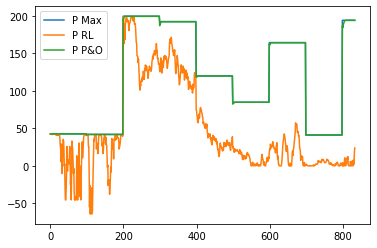

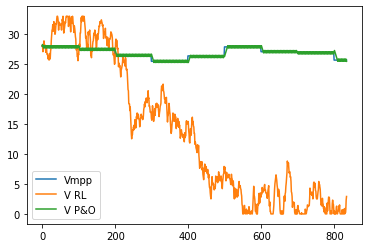

INFO 2020-11-18 10:19:02,349 PO Efficiency=99.87892064901877
INFO 2020-11-18 10:19:02,350 RL Efficiency=33.93119511116677


In [4]:
agent.exp_train_source.play_episode()
env.render_vs_true(po=True)

INFO 2020-11-18 10:19:07,096 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 810.89it/s]
INFO 2020-11-18 10:19:08,128 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 208390.89it/s]


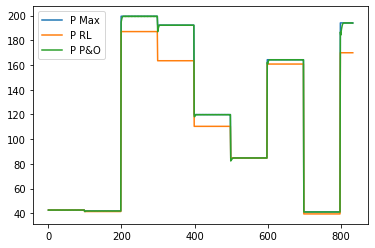

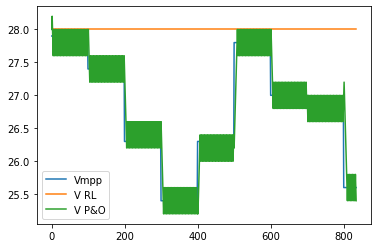

INFO 2020-11-18 10:19:08,713 PO Efficiency=99.87892064901877
INFO 2020-11-18 10:19:08,714 RL Efficiency=95.11829970657818


In [5]:
agent.exp_test_source.play_episode()
test_env.render_vs_true(po=True)

In [6]:
obs = env.reset()
agent.policy(obs), agent.test_policy(obs), agent.net(torch.tensor(obs, dtype=torch.float32))

(0.042810988,
 0.041951198,
 (tensor([0.0420], grad_fn=<AddBackward0>),
  tensor([0.6965], grad_fn=<SoftplusBackward>),
  tensor([-0.0474], grad_fn=<AddBackward0>)))

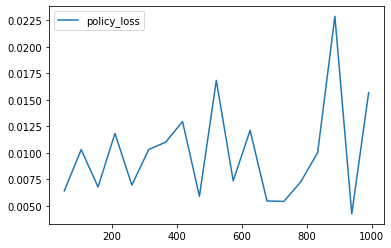

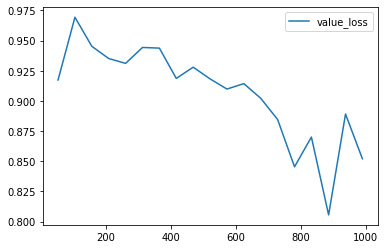

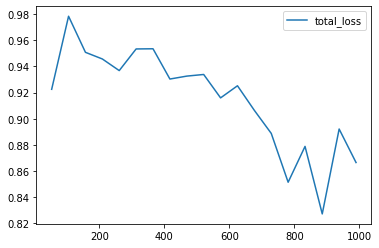

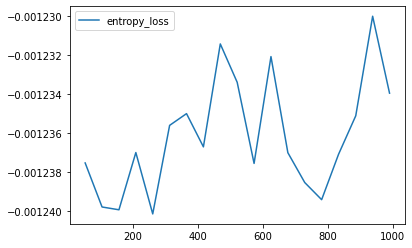

In [7]:
agent.plot_performance(['policy_loss', 'value_loss', 'total_loss', 'entropy_loss'])